# Tutorial 2: five-omics integration 

### This tutorial demonstrates STAOmics’s ablility to integrate five unpaired P22 mouse brain slices: RNA, ATAC, H3K27ac, H3K27me3, and H3K4me3. The raw and processed data can be downloaded from GSE205055 and https://drive.google.com/drive/folders/1_V4IAxblPzNVj6P53PWjVO07lQLn2gIy?usp=sharing, respectively.

In [1]:
import warnings
warnings.filterwarnings('ignore')

## setting for bedtools calling in jupyter
import os
from os import path
import sys
bin_dir = path.dirname(sys.executable)
os.environ['PATH'] += os.pathsep + bin_dir
# print(os.pathsep + bin_dir)

import pandas as pd
import anndata as ad
import networkx as nx
import scanpy as sc
import STAOmics
import numpy as np
import scipy.sparse as sp
from itertools import chain

STAOmics.config.BEDTOOLS_PATH = "/mnt/disk4/xzhou/anaconda3/envs/STAOmics/bin/" 

## Step 1: Data preprocessing

In [2]:
datadir = '/mnt/disk2/xzhou/code/pycharm_ATAC/STAOmics_v0/data/P22/'

In [3]:
stH3K27ac = sc.read_h5ad(datadir+'P22_H3K27ac_cuttag.h5ad')
stH3K27me3 = sc.read_h5ad(datadir+'P22_H3K27me3_cuttag.h5ad')
stH3K4me3 = sc.read_h5ad(datadir+'P22_H3K4me3_cuttag.h5ad')
statac = sc.read_h5ad(datadir+'P22_ATAC_atac.h5ad')
strna = sc.read_h5ad(datadir+'P22_H3K27ac_RNA.h5ad')

In [4]:
strna.layers['counts'] = strna.X.astype(int).copy()
statac.layers['counts'] = statac.X.astype(int).copy()
stH3K4me3.layers['counts'] = stH3K4me3.X.astype(int).copy()
stH3K27me3.layers['counts'] = stH3K27me3.X.astype(int).copy()
stH3K27ac.layers['counts'] = stH3K27ac.X.astype(int).copy()

### Preprocess spRNA-seq data

In [5]:
sc.pp.highly_variable_genes(strna, n_top_genes=5000, flavor="seurat_v3")
sc.pp.normalize_total(strna) #, target_sum=1e4
sc.pp.log1p(strna)
strna = strna[:, strna.var['highly_variable']]
strna.obsm['X_feat'] = strna.X.toarray()

### Preprocess spCUT&Tag-seq data

In [6]:
statac.obsm['X_lsi'] = STAOmics.utils.Epigenome_preprocess(statac.copy(), key='X_lsi')
stH3K27ac.obsm['X_lsi'] = STAOmics.utils.Epigenome_preprocess(stH3K27ac.copy(), key='X_lsi')
stH3K27me3.obsm['X_lsi'] = STAOmics.utils.Epigenome_preprocess(stH3K27me3.copy(), key='X_lsi')
stH3K4me3.obsm['X_lsi'] = STAOmics.utils.Epigenome_preprocess(stH3K4me3.copy(), key='X_lsi')

### Prior feature graph construction

In [7]:
STAOmics.data.get_gene_annotation(
    strna, gtf=datadir+"gencode.vM25.chr_patch_hapl_scaff.annotation.gtf.gz",
    gtf_by="gene_name"
)
strna.var.loc[:, ["chrom", "chromStart", "chromEnd"]].head()

strna = strna[:, ~strna.var['chrom'].isna()]

In [8]:
strna.var.loc[:, ["chrom", "chromStart", "chromEnd"]].head()

,chrom,chromStart,chromEnd
Ppp1r14c,chr10,3366056.0,3464975.0
Plekhg1,chr10,3740363.0,3967303.0
Mthfd1l,chr10,3973117.0,4167081.0
Ccdc170,chr10,4482501.0,4562231.0
Gm10097,chr10,5069191.0,5071975.0


In [9]:
split = stH3K27ac.var_names.str.split(r"[:-]")
stH3K27ac.var["chrom"] = split.map(lambda x: x[0])
stH3K27ac.var["chromStart"] = split.map(lambda x: x[1]).astype(int)
stH3K27ac.var["chromEnd"] = split.map(lambda x: x[2]).astype(int)
stH3K27ac.var.head()

,chrom,chromStart,chromEnd
chr1-3094679-3094964,chr1,3094679,3094964
chr1-3119499-3119936,chr1,3119499,3119936
chr1-3121345-3121681,chr1,3121345,3121681
chr1-3250538-3251680,chr1,3250538,3251680
chr1-3263733-3264531,chr1,3263733,3264531


In [10]:
split = statac.var_names.str.split(r"[:-]")
statac.var["chrom"] = split.map(lambda x: x[0])
statac.var["chromStart"] = split.map(lambda x: x[1]).astype(int)
statac.var["chromEnd"] = split.map(lambda x: x[2]).astype(int)
statac.var.head()

,chrom,chromStart,chromEnd
chr1-3094750-3095365,chr1,3094750,3095365
chr1-3119542-3120773,chr1,3119542,3120773
chr1-3121337-3121583,chr1,3121337,3121583
chr1-3210558-3211041,chr1,3210558,3211041
chr1-3217182-3217395,chr1,3217182,3217395


In [11]:
split = stH3K27me3.var_names.str.split(r"[:-]")
stH3K27me3.var["chrom"] = split.map(lambda x: x[0])
stH3K27me3.var["chromStart"] = split.map(lambda x: x[1]).astype(int)
stH3K27me3.var["chromEnd"] = split.map(lambda x: x[2]).astype(int)
stH3K27me3.var.head()

,chrom,chromStart,chromEnd,highly_variable
chr1-3003174-3003765,chr1,3003174,3003765,False
chr1-3670444-3672519,chr1,3670444,3672519,False
chr1-3756434-3757164,chr1,3756434,3757164,False
chr1-3915513-3915977,chr1,3915513,3915977,False
chr1-4038897-4039205,chr1,4038897,4039205,True


In [12]:
split = stH3K4me3.var_names.str.split(r"[:-]")
stH3K4me3.var["chrom"] = split.map(lambda x: x[0])
stH3K4me3.var["chromStart"] = split.map(lambda x: x[1]).astype(int)
stH3K4me3.var["chromEnd"] = split.map(lambda x: x[2]).astype(int)
stH3K4me3.var.head()

,chrom,chromStart,chromEnd
chr1-3433875-3434074,chr1,3433875,3434074
chr1-3670113-3672402,chr1,3670113,3672402
chr1-4471407-4471612,chr1,4471407,4471612
chr1-4491703-4493730,chr1,4491703,4493730
chr1-4496203-4496619,chr1,4496203,4496619


In [13]:
guidance_atac = STAOmics.genomics.rna_anchored_guidance_graph(strna, statac, propagate_highly_variable = True) 
guidance_H3K4me3 = STAOmics.genomics.rna_anchored_guidance_graph(strna, stH3K4me3, propagate_highly_variable = True)
guidance_H3K27ac = STAOmics.genomics.rna_anchored_guidance_graph(strna, stH3K27ac, propagate_highly_variable = True)
guidance_H3K27me3 = STAOmics.genomics.rna_anchored_guidance_graph(strna, stH3K27me3, propagate_highly_variable = True, signs=[-1])  # negative for H3K27me3

graph_tri = STAOmics.graph.compose_multigraph(guidance_atac, guidance_H3K4me3, guidance_H3K27ac, guidance_H3K27me3)
len(graph_tri)

window_graph: 100%|██████████| 4527/4527 [00:00<00:00, 6786.81it/s]


441202

In [14]:
STAOmics.graph.check_graph(graph_tri, [strna, statac, stH3K4me3, stH3K27ac, stH3K27me3])

[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] check_graph: All checks passed!


In [15]:
strna.var['highly_variable'].sum()

4527

In [16]:
nx.write_graphml(graph_tri, datadir+"P22_five_omics_guidance.graphml.gz")

strna.write(datadir+"P22_five_omics_RNA_pp.h5ad", compression="gzip")
statac.write(datadir+"P22_five_omics_ATAC_pp.h5ad", compression="gzip")
stH3K27ac.write(datadir+"P22_five_omics_H3K27ac_pp.h5ad", compression="gzip")
stH3K4me3.write(datadir+"P22_five_omics_H3K4me3_pp.h5ad", compression="gzip")
stH3K27me3.write(datadir+"P22_five_omics_H3K27me3_pp.h5ad", compression="gzip")

## Step 2: Model training

In [17]:
strna = ad.read_h5ad(datadir+"P22_five_omics_RNA_pp.h5ad")
statac = ad.read_h5ad(datadir+"P22_five_omics_ATAC_pp.h5ad")
stH3K27ac = ad.read_h5ad(datadir+"P22_five_omics_H3K27ac_pp.h5ad")
stH3K4me3 = ad.read_h5ad(datadir+"P22_five_omics_H3K4me3_pp.h5ad")
stH3K27me3 = ad.read_h5ad(datadir+"P22_five_omics_H3K27me3_pp.h5ad")
guidance = nx.read_graphml(datadir+"P22_five_omics_guidance.graphml.gz")

strna.X = sp.csr_matrix(strna.X)
statac.X = sp.csr_matrix(statac.X)
stH3K27ac.X = sp.csr_matrix(stH3K27ac.X)
stH3K4me3.X = sp.csr_matrix(stH3K4me3.X)
stH3K27me3.X = sp.csr_matrix(stH3K27me3.X)

strna.obs_names = strna.obs_names+'_rna'
statac.obs_names = statac.obs_names+'_atac'
stH3K27ac.obs_names = stH3K27ac.obs_names+'_H3K27ac'
stH3K4me3.obs_names = stH3K4me3.obs_names+'_H3K4me3'
stH3K27me3.obs_names = stH3K27me3.obs_names+'_H3K27me3'

In [18]:
# Constructing the spatial neighbor network
STAOmics.utils.Cal_Spatial_Net(strna, rad_cutoff=1.3)  # the spatial network are saved in adata.uns[‘adj’]
STAOmics.utils.Cal_Spatial_Net(statac, rad_cutoff=1.3)
STAOmics.utils.Cal_Spatial_Net(stH3K27ac, rad_cutoff=1.3)
STAOmics.utils.Cal_Spatial_Net(stH3K4me3, rad_cutoff=1.3)
STAOmics.utils.Cal_Spatial_Net(stH3K27me3, rad_cutoff=1.3)
# STAOmics.utils.Stats_Spatial_Net(statac)

------Calculating spatial graph...
The graph contains 37084 edges, 9370 cells.
3.9577 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 36464 edges, 9215 cells.
3.9570 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 37084 edges, 9370 cells.
3.9577 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 37796 edges, 9548 cells.
3.9585 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 38612 edges, 9752 cells.
3.9594 neighbors per cell on average.


In [19]:
## only highly_variable features are used
guidance_hvf = guidance.subgraph(chain(
    strna.var.query("highly_variable").index,
    # statac.var.index
    statac.var.query("highly_variable").index,
    stH3K27ac.var.query("highly_variable").index,
    stH3K4me3.var.query("highly_variable").index,
    stH3K27me3.var.query("highly_variable").index,
)).copy()

vertices = sorted(guidance_hvf.nodes)

In [20]:
## Dataset configure
STAOmics.models.configure_dataset(strna, "NB", use_highly_variable=True, use_layer="counts", use_rep="X_feat", use_obs_names=True)
STAOmics.models.configure_dataset(statac, "NB", use_highly_variable=True, use_layer="counts", use_rep="X_lsi", use_obs_names=True)
STAOmics.models.configure_dataset(stH3K27ac, "NB", use_highly_variable=True, use_layer="counts", use_rep="X_lsi", use_obs_names=True)
STAOmics.models.configure_dataset(stH3K4me3, "NB", use_highly_variable=True, use_layer="counts", use_rep="X_lsi", use_obs_names=True)
STAOmics.models.configure_dataset(stH3K27me3, "NB", use_highly_variable=True, use_layer="counts", use_rep="X_lsi", use_obs_names=True)

In [21]:
model = STAOmics.models.train(
    {"RNA": strna, "ATAC": statac, "H3K27ac": stH3K27ac, "H3K4me3": stH3K4me3, "H3K27me3": stH3K27me3}, guidance_hvf,
    fit_kws={"directory": "P22_five_omics"}, is_finetune = True, OT_pair=[('RNA','ATAC'),('RNA','H3K27ac'),('RNA','H3K4me3'),('RNA','H3K27me3')]  
    ### compile_kws={"lam_align": 0.05}
)

[INFO] train: Pretraining STAOmics model...2025-06-24 21:28:41
[INFO] autodevice: Using GPU 3 as computation device.
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] STAOmicsModel: Setting `graph_batch_size` = 79214
[INFO] STAOmicsModel: Setting `max_epochs` = 73
[INFO] STAOmicsModel: Setting `patience` = 7
[INFO] STAOmicsModel: Setting `reduce_lr_patience` = 4
[INFO] STAOmicsTrainer: Using training directory: "P22_five_omics/pretrain"
[INFO] STAOmicsTrainer: [Epoch 10] train={'g_nll': 0.413, 'g_kl': 0.002, 'g_elbo': 0.416, 'x_RNA_nll': 0.263, 'x_RNA_kl': 0.004, 'x_RNA_elbo': 0.267, 'x_ATAC_nll': 0.118, 'x_ATAC_kl': 0.001, 'x_ATAC_elbo': 0.119, 'x_H3K27ac_nll': 0.091, 'x_H3K27ac_kl': 0.001, 'x_H3K27ac_elbo': 0.092, 'x_H3K4me3_nll': 0.176, 'x_H3K4me3_kl': 0.002, 'x_H3K4me3_elbo': 0.178, 'x_H3K27me3_nll': 0.074, 'x_H3K27me3_kl': 0.001, 'x_H3K27

2025-06-24 22:44:11,919 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "46"...
[INFO] EarlyStopping: Restoring checkpoint "46"...
[INFO] train: FGW OT mapping from source RNA to ATAC
[INFO] train: downsample source data to 5000...
[INFO] train: downsample target data to 5000...
How many source profiles were paired to an destination profile of the same cluster type: 0.916
[INFO] train: FGW OT mapping from source RNA to H3K27ac
[INFO] train: downsample source data to 5000...
[INFO] train: downsample target data to 5000...
How many source profiles were paired to an destination profile of the same cluster type: 0.9386
[INFO] train: FGW OT mapping from source RNA to H3K4me3
[INFO] train: downsample source data to 5000...
[INFO] train: downsample target data to 5000...
How many source profiles were paired to an destination profile of the same cluster type: 0.899
[INFO] train: FGW OT mapping from source RNA to H3K27me3
[INFO] train: downsample source data to 5000...
[INFO] train: downsample target data to 5000...
How ma

2025-06-24 23:31:31,230 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "32"...
[INFO] EarlyStopping: Restoring checkpoint "32"...
[INFO] train: End of training...2025-06-24 23:31:31


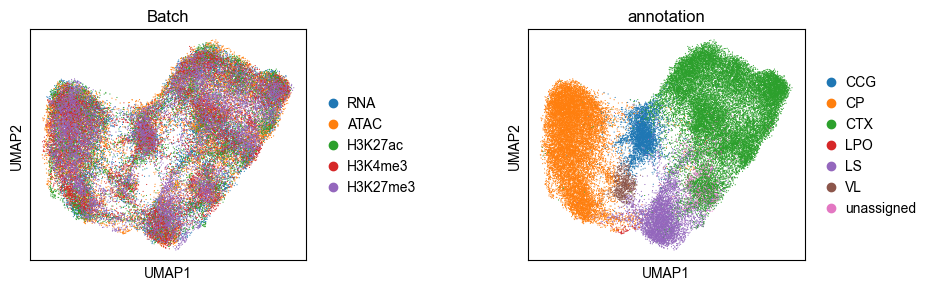

In [22]:
strna.obsm["X_STAOmics"] = model.encode_data_minibatch("RNA", strna)
statac.obsm["X_STAOmics"] = model.encode_data_minibatch("ATAC", statac)
stH3K27ac.obsm["X_STAOmics"] = model.encode_data_minibatch("H3K27ac", stH3K27ac)
stH3K4me3.obsm["X_STAOmics"] = model.encode_data_minibatch("H3K4me3", stH3K4me3)
stH3K27me3.obsm["X_STAOmics"] = model.encode_data_minibatch("H3K27me3", stH3K27me3)

combined = ad.concat([strna, statac, stH3K27ac, stH3K4me3, stH3K27me3], label='Batch', keys=['RNA', 'ATAC', "H3K27ac", "H3K4me3", 'H3K27me3'],join='outer')
sc.pp.neighbors(combined, use_rep="X_STAOmics", metric="cosine")
sc.tl.umap(combined)

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams["figure.figsize"] = (2, 2)
plt.rcParams['font.size'] = 10
plt.rcParams['legend.handletextpad'] = 0.01 
fig, ax = plt.subplots(1, 2, figsize=(10, 3), gridspec_kw={'wspace': 0.8, 'hspace': 0.1})

sc.pl.umap(combined, color=["Batch"], wspace=1, show=False, ax=ax[0])
sc.pl.umap(combined, color=['annotation'], legend_fontsize=10, show=False, ax=ax[1])   #, legend_loc=None
plt.show()

In [23]:
sc.tl.leiden(combined, random_state=666, key_added="leiden", resolution=1.4) 

strna.obs['leiden'] = combined.obs['leiden'][combined.obs['Batch']=='RNA'].values
statac.obs['leiden'] = combined.obs['leiden'][combined.obs['Batch']=='ATAC'].values
stH3K27ac.obs['leiden'] = combined.obs['leiden'][combined.obs['Batch']=='H3K27ac'].values
stH3K4me3.obs['leiden'] = combined.obs['leiden'][combined.obs['Batch']=='H3K4me3'].values
stH3K27me3.obs['leiden'] = combined.obs['leiden'][combined.obs['Batch']=='H3K27me3'].values

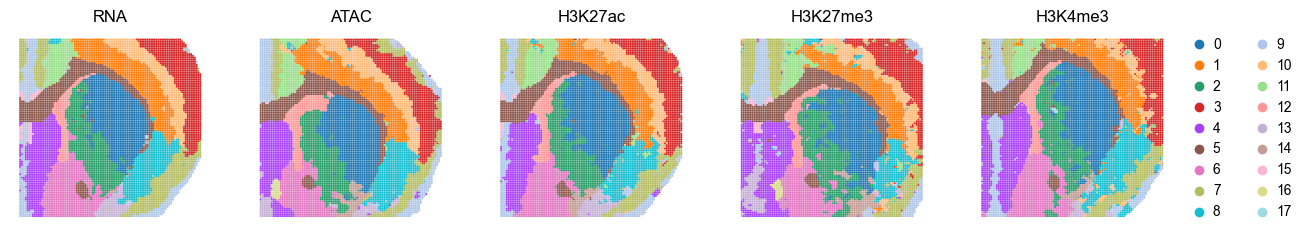

In [24]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams["figure.figsize"] = (3, 3)
plt.rcParams['font.size'] = 10
plt.rcParams['legend.handletextpad'] = 0.01
# plt.rcParams['legend.labelspacing'] = 0.1 

spot_size = 30
fig, ax = plt.subplots(1, 5, figsize=(15, 3), gridspec_kw={'wspace': 0.2, 'hspace': 0.1})

spot_size = 1.1 
sc.pl.spatial(strna, color='leiden', cmap="viridis", show=False, frameon=False, spot_size=spot_size, title=['RNA'], ax=ax[0], legend_loc=None)
sc.pl.spatial(statac, color='leiden', cmap="viridis", show=False, frameon=False, spot_size=spot_size,title=['ATAC'], ax=ax[1], legend_loc=None)
sc.pl.spatial(stH3K27ac, color='leiden', cmap="viridis", show=False, frameon=False, spot_size=spot_size,title=['H3K27ac'], ax=ax[2], legend_loc=None)
sc.pl.spatial(stH3K27me3, color='leiden', cmap="viridis", show=False, frameon=False, spot_size=spot_size,title=['H3K27me3'], ax=ax[3], legend_loc=None)
sc.pl.spatial(stH3K4me3, color='leiden', cmap="viridis", show=False, frameon=False, spot_size=spot_size,title=['H3K4me3'], ax=ax[4])
plt.show()